# Project:  Articles Classification

## Table of Contents

<ul>
<li><a href="#PS">Problem Statement</a></li>
<li><a href="#DG">Data Gathering</a></li>
<li><a href="#A&C">Assessing & Cleaning</a></li>
<li><a href="#SP">Splitting the Data</a></li>
<li><a href="#TC">Data Transformation & Classification</a></li>
</ul>

<a id="PS"><a/>
# Problem Statement

>Classifying the type of the acticles based on the content of its body by testing different Algorithms.

<a id="DG"><a/>
# Data Gathering

In [1]:
#Importing the needed libraries
import urllib.request
import json 
import pandas as pd

In [2]:
#Reading Json URL
response = urllib.request.urlopen('https://knowledge-officer-assessments.s3.us-east-2.amazonaws.com/machine-learning/assignment%231/articles.json')
data = json.loads(response.read())
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [3]:
#Transforming the data from json to DataFrame
data_new = pd.DataFrame.from_dict(data)
print(data_new.columns)
data_new

Index(['body', 'title', 'category'], dtype='object')


,body,title,category
0,Protecting Netflix Viewing Privacy at Scale\r\...,Protecting Netflix Viewing Privacy at Scale,Engineering
1,Introducing Winston — Event driven Diagnostic ...,Introducing Winston - Event driven Diagnostic ...,Engineering
2,Performance & Usage at Instagram\r\n\r\nAt Ins...,Performance & Usage at Instagram,Engineering
3,The simple example of calculating and formatti...,Refactoring a javascript video store,Engineering
4,Billing applications have transactions that ne...,Netflix Billing Migration to AWS - Part III,Engineering
...,...,...,...
2476,"At the Early Stage, Focus on Unit Economic Pro...","At the Early Stage, Focus on Unit Economic Pro...",Startups & Business
2477,5 Tips to Nail a Successful Product Launch\n\n...,5 Tips to Nail a Successful Product Launch,Startups & Business
2478,Routes to Defensibility for your AI Startup\n\...,Routes to Defensibility for your AI Startup,Engineering
2479,Faster. Faster. Faster.\r\n\r\nI’d like to tal...,Faster. Faster. Faster.,Product & Design


### Now we have 3 features ['body','title','category'], we need to fit our model with the appropriate words using "body" or "title" so the model can be able to categorize the new articles to the correct category which they belong to.

<a id='A&C'><a/>
# Data Assessing & Cleaning

In [4]:
#checing the missing values and the data type
data_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2481 entries, 0 to 2480
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   body      2481 non-null   object
 1   title     2481 non-null   object
 2   category  2481 non-null   object
dtypes: object(3)
memory usage: 58.3+ KB


In [5]:
data_new.dropna(inplace=True)
data_new.drop_duplicates(inplace=True)

In [6]:
#Councting the number of each entries in category column.
data_new['category'].value_counts()

Startups & Business    1062
Product & Design        848
Engineering             551
Name: category, dtype: int64

In [7]:
#ploting the number of the enteries.
data_new['category'].value_counts().plot.barh(figsize=(7,3));

### The classes are not equal so we will be sampling the same size of sample from the data for each class,to make the data balanced when we are fitting the model.

In [8]:
#Sampling the same sample size of "Engineering" for "Product & Design" & "Startups & Business"

product_data = data_new[data_new['category'] == 'Product & Design'].sample(n=551, replace=False)
startup_data = data_new[data_new['category'] == 'Startups & Business'].sample(n=551, replace=False)

In [9]:
#Filtering the data then concatenating the data into 1 DataFrame and shuffle all of the data again

engineering_data = data_new[data_new['category'] == 'Engineering']
balanced_data = pd.concat([product_data,startup_data,engineering_data]).sample(frac=1,replace=False)
balanced_data = balanced_data.reset_index()

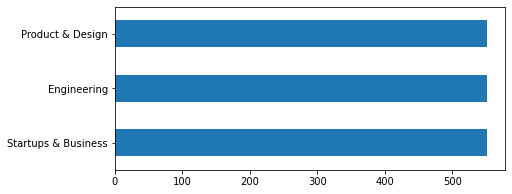

In [10]:
#Plotting the data again after sampling
balanced_data['category'].value_counts().plot.barh(figsize=(7,3));

In [11]:
balanced_data.head(10)

,index,body,title,category
0,762,"Public relations can mean a variety of things,...",What Public Relations at a Startup is Really Like,Startups & Business
1,564,This is a follow-up to the discussion that was...,Abstractions and the role of a framework,Engineering
2,652,Video:Slides:Recently Karl Ulrich asked me to ...,Video: The Art of Product Management,Product & Design
3,907,Here’s what I know.\n\nGoing through a life-al...,How a Facebook designer overcame imposter synd...,Product & Design
4,1105,Today’s product teams are built to move fast a...,Breaking rules in your product design process,Product & Design
5,1452,"These days, startup founders spend a lot of ti...",Why PRODUCT DEMO is a secret weapon of every s...,Startups & Business
6,377,Editor’s note: We’ve republished this article—...,"UX design tips for your app, part 1",Product & Design
7,871,Congratulations—you’ve won the pitch and got t...,Understanding your client: 7 difficult questio...,Product & Design
8,798,Running a mock code review\r\n\r\nAt the end o...,A better way to interview software engineers,Engineering
9,2373,Three diseases your product can catch (and how...,Three diseases your product can catch (and how...,Product & Design


In [12]:
balanced_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1653 entries, 0 to 1652
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   index     1653 non-null   int64 
 1   body      1653 non-null   object
 2   title     1653 non-null   object
 3   category  1653 non-null   object
dtypes: int64(1), object(3)
memory usage: 51.8+ KB


### We will be dropping the Index column from our DataFrame and the Title column as we are going to tokanize the Body only to fit it into our model.


In [13]:
#We will be dropping the Index Title from our Data.
new_data = balanced_data.drop(['index','title'],axis=1)

In [14]:
new_data.head(10)

,body,category
0,"Public relations can mean a variety of things,...",Startups & Business
1,This is a follow-up to the discussion that was...,Engineering
2,Video:Slides:Recently Karl Ulrich asked me to ...,Product & Design
3,Here’s what I know.\n\nGoing through a life-al...,Product & Design
4,Today’s product teams are built to move fast a...,Product & Design
5,"These days, startup founders spend a lot of ti...",Startups & Business
6,Editor’s note: We’ve republished this article—...,Product & Design
7,Congratulations—you’ve won the pitch and got t...,Product & Design
8,Running a mock code review\r\n\r\nAt the end o...,Engineering
9,Three diseases your product can catch (and how...,Product & Design


In [15]:
#Replacing the new line with spaces
new_data['body'] = new_data['body'].replace('\r',' ').replace('\n',' ')
new_data['body'].dtype

dtype('O')

### As the data has a lot Regex and Symbols that need to be parsed and stopwords to be removed before the modeling step. We will be defining a new Function to clean the body column and then we will apply it to the column.

In [16]:
#Imporing Regex and nltk Libraries
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

#Defining all the needed variables to be cleaned

replace_by_space_re = re.compile('[/(){}\[\]\|@,;]')
bad_symbols_re = re.compile('[^0-9a-z #+_]')
remove_num_re = re.compile('[\d+]')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
#Defining a function that clean the text.

def clean_text(text):
    text = text.lower()  #lowercase text
    text = replace_by_space_re.sub(' ', text) #replace REPLACE_BY_SPACE_RE symbols by space in text
    text = text.replace('x', '') #Remove the X values
    text = text.replace('\r',' ').replace('\n',' ') #Remove the new lines values
    text = remove_num_re.sub('', text) #removing numbers
    text = bad_symbols_re.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in stopwords) # delete stopwords from text
    return text

In [18]:
#Appling the clean_text function on the body column.
new_data["body"] = new_data["body"].apply(clean_text)

In [19]:
new_data.head(15)

,body,category
0,public relations mean variety things especiall...,Startups & Business
1,followup discussion started last week publishe...,Engineering
2,videoslidesrecently karl ulrich asked give tal...,Product & Design
3,heres know going lifealtering international mo...,Product & Design
4,todays product teams built move fast ship prod...,Product & Design
5,days startup founders spend lot time thinking ...,Startups & Business
6,editors note weve republished articleenjoy don...,Product & Design
7,congratulationsyouve pitch got job designer th...,Product & Design
8,running mock code review end perfect code revi...,Engineering
9,three diseases product catch prevent youve cre...,Product & Design


## The data is cleaned and ready to be splitted to train, validation and test sets.

<a id="SP"><a/>
# Splitting the Data

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
#split the data to X and y then to 60% train, 15% validation and 15% test
X = new_data['body']
y = new_data['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=2)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=2)

In [22]:
#Saving the data to Excel files
train = pd.concat([X_train, y_train], axis=1)
train.to_excel('Train.xlsx')

validation = pd.concat([X_val, y_val], axis=1)
validation.to_excel('Validation.xlsx')

test = pd.concat([X_test, y_test], axis=1)
test.to_excel('Test.xlsx')

In [23]:
print(train.shape)
print(validation.shape)
print(test.shape)
print(new_data.shape)

(1194, 2)
(211, 2)
(248, 2)
(1653, 2)


<a id='TC'><a/>
# Data Transformation & Classification

In [24]:
#importing classifier, transformers and metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [25]:
#creating Naive Bayes Pipeline
NB = Pipeline([('tfidf',TfidfVectorizer(stop_words=stopwords)),
              ('clf',OneVsRestClassifier(MultinomialNB(fit_prior=True,class_prior=None)))])

In [26]:
#fitting the data and evaluate the model on validation set
NB.fit(X_train, y_train)

y_pred = NB.predict(X_val)

accuracy = accuracy_score(y_val,y_pred)
print(accuracy)

0.8672985781990521


In [27]:
#evaluating the model on test set
final_prediction = NB.predict(X_test)

model_accuracy = accuracy_score(y_test,final_prediction)
print(model_accuracy)

0.8548387096774194
